# Dependencies

In [1]:
import sys
# import warnings
# warnings.filterwarnings('ignore')

from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

import matplotlib.pyplot as plt

# Loading dataset

In [2]:
def plotly_df(df, title=''):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index,
                           y=df[column],
                           mode='lines',
                           name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [3]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

# Analysis

In [4]:
# TODO: add correspinding datasets for showing potential (intended use, best choice) of each method

## Rolling mean

### Single value

In [5]:
def rolling_mean(series, window_size):
    return np.average(series[-window_size:])

In [6]:
rolling_mean(dataset.Users, 24)

29858.333333333332

### Domain

In [7]:
def apply_rolling_mean(series, window_size):
    """
    series - dataframe with timeseries
    window_size - rolling window size
    """

    # actual values
    plt.figure(figsize=(15, 5))
    plt.plot(series[window_size:], label="Actual values")
        
    # rolling mean
    rolling_mean = series.rolling(window=window_size).mean()
    plt.title("Rolling mean\n window size = %s" % window_size)
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # confidence intervals
    rolling_std =  series.rolling(window=window_size).std()
    upper_bound = rolling_mean + 1.96 * rolling_std
    lower_bound = rolling_mean - 1.96 * rolling_std
    plt.plot(upper_bound, "r--", label="Upper bound / Lower bound")
    plt.plot(lower_bound, "r--")
    
    # plot params
    plt.legend(loc="upper left")
    plt.grid(True)

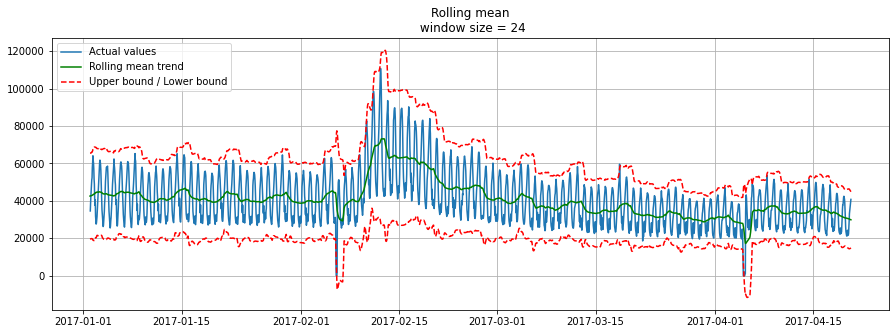

In [8]:
# mean by last day
apply_rolling_mean(dataset, 24)

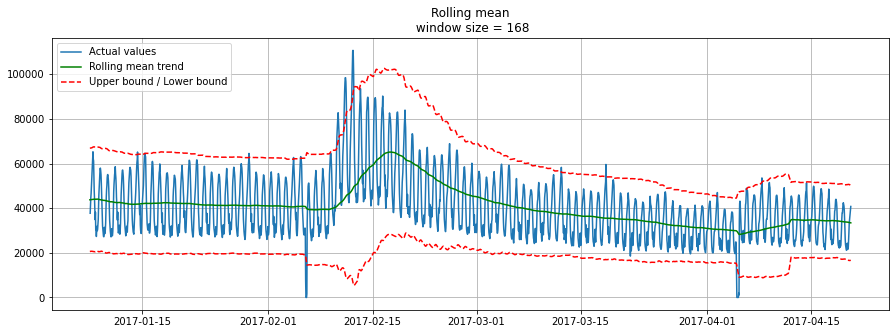

In [9]:
# mean by last week
apply_rolling_mean(dataset, 24 * 7)

## Rolling weighted mean

### Single value

In [10]:
def rolling_weighted_mean(series, weights):
    result = 0
    weights.reverse()
    for i in range(len(weights)):
        result += series[-i - 1] * weights[i]
    return result

# single value
rolling_weighted_mean(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

35967.55

### Domain

In [11]:
# TODO: apply to whole domain

## Exponential rolling mean

In [12]:
def exp_rolling_mean(series, alpha):
    result = [series[0]]
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return result

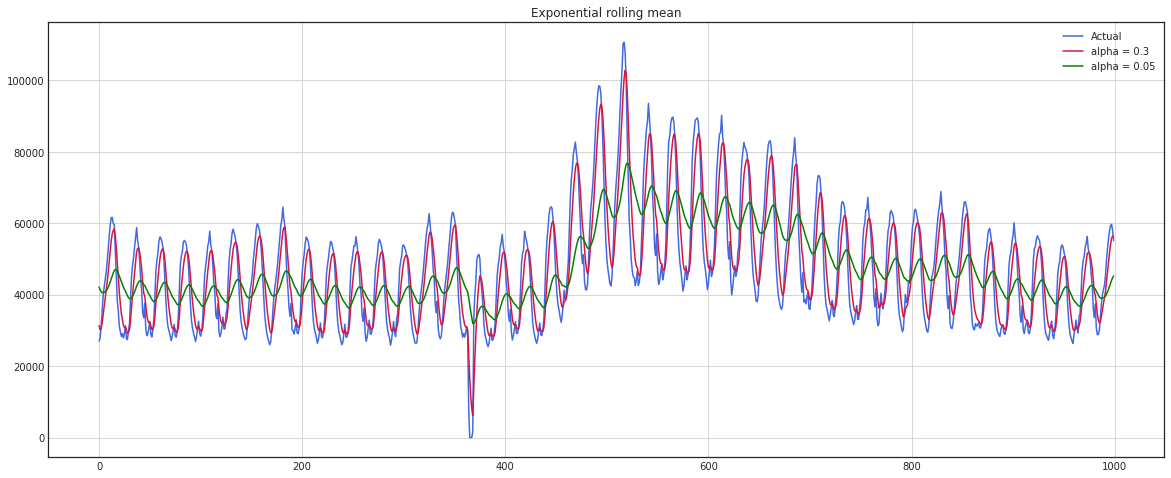

In [13]:
colors = {
    'red': '#FF0000',
    'crimson': '#DC143C',
    
    'green': '#008000',
    'lime_green': '#32CD32',
    
    'blue': '#0000FF',
    'royal_blue': '#4169E1',
}


# viewport
left_bound = 500
right_bound = 1500
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    
    plt.plot(dataset.Users.values[left_bound:right_bound], colors['royal_blue'], label="Actual")
    
    for alpha, color in [(0.3, colors['crimson']), (0.05, colors['green'])]:
        plt.plot(exp_rolling_mean(dataset.Users, alpha)[left_bound:right_bound], color, label="alpha = %s" % alpha)
    
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential rolling mean")
    plt.grid(True)

## Double exponential rolling (Holt model)

In [14]:
# TODO: predint d next points?
def double_exp_rolling(series, alpha, beta):
    result = [series[0]]
    
    level = series[0]
    trend = series[1] - series[0]
    
    # predicting two points ahead
    d = 2
    for i in range(1, len(series) + (d - 1)):
        if i < len(series):
            value = series[i]
        else:
            value = result[-1]
            
            
        last_level = level
        last_trend = trend
        
        level = alpha * value + (1 - alpha) * (last_level + last_trend)
        trend = beta * (level - last_level) + (1 - beta) * last_trend
        
        result.append(level + trend)
        
    return result

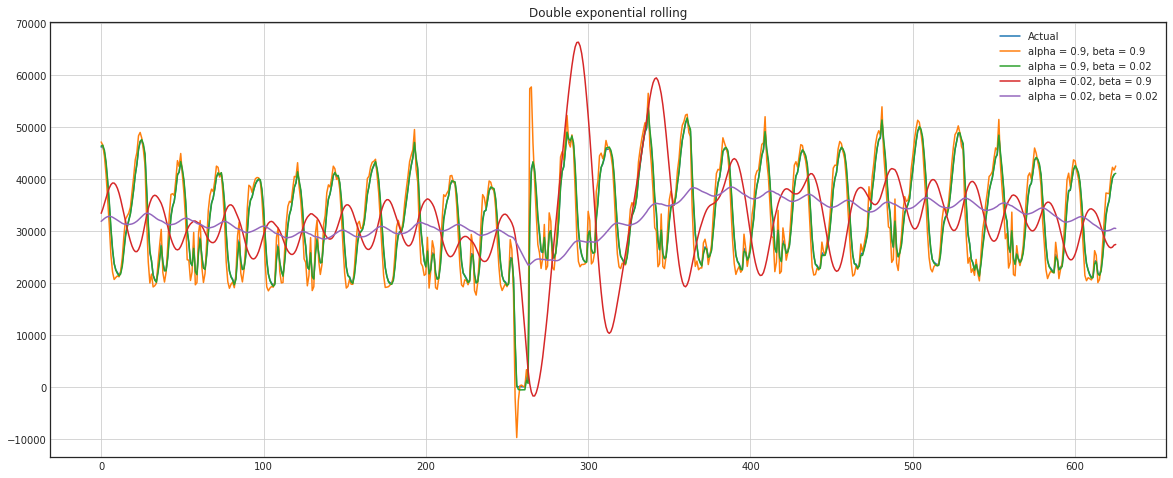

In [15]:
# viewport
left_bound = 2000
# right_bound = 1500
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    
    plt.plot(dataset.Users.values[left_bound:], label="Actual")
    
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exp_rolling(dataset.Users, alpha, beta)[left_bound:],
                     label="alpha = %s, beta = %s" % (alpha, beta))
    
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double exponential rolling")
    plt.grid(True)